Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Best score is: 0.9882500000000001
Best estimator is: XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, objective='multi:softprob', ...)
Best Params are: {'learning_rate': 0.05, 'max_dept

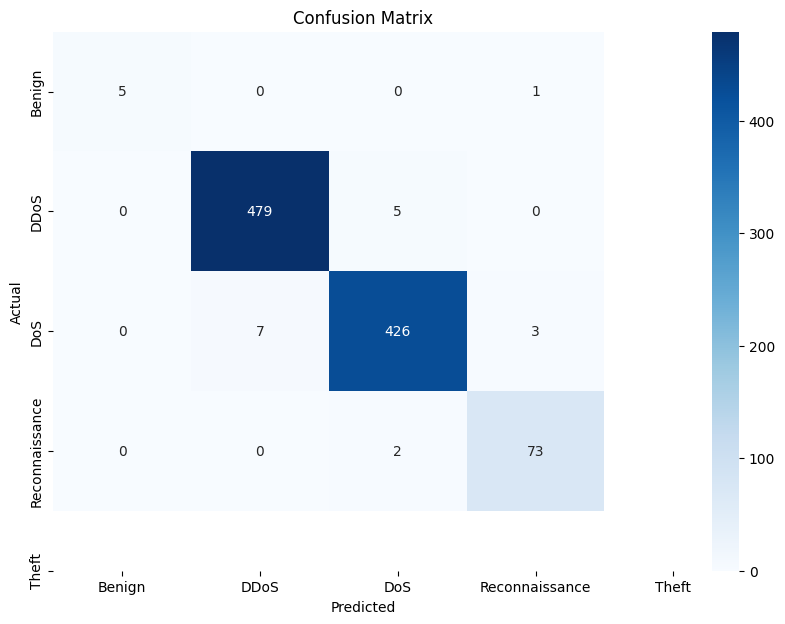

['tuned_xgboost_model.pkl']

In [1]:
# Import necessary libraries
import pandas as pd
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from xgboost import XGBClassifier

from warnings import filterwarnings
filterwarnings('ignore')

# Load CSV files from Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Define file paths for training and testing datasets
train_file_path = '/content/drive/My Drive/IDS data sets/NF-BoT-IoT-V2_5000 samples_minmax_normalized_train.csv'
test_file_path = '/content/drive/My Drive/IDS data sets/NF-BoT-IoT-V2_5000 samples_minmax_normalized_test.csv'

# Load the datasets into DataFrames
train_data = pd.read_csv(train_file_path)
test_data = pd.read_csv(test_file_path)

# Separate features and labels for training and testing datasets
X_train = train_data.iloc[:, :-2]  # All columns except the last two (features)
y_train = train_data.iloc[:, -1]    # Last column (label names)

X_test = test_data.iloc[:, :-2]     # All columns except the last two (features)
y_test = test_data.iloc[:, -1]       # Last column (label names)

X_train = X_train.dropna(axis=1)
X_test = X_test.dropna(axis=1)

# Encode target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

# Define the GridSearch function
def GrdSrch_Tune(model, X, y, params):
    clf = GridSearchCV(model, params, scoring='recall_weighted', cv=5, n_jobs=-1)
    clf.fit(X, y)

    print("Best score is:", clf.best_score_)
    print("Best estimator is:", clf.best_estimator_)
    print("Best Params are:", clf.best_params_)

    return clf.best_estimator_

# Define the XGBoost model
xgb_model = XGBClassifier(use_label_encoder=True, eval_metric='logloss', random_state=42)

# Define parameter grid for GridSearchCV
param_grid = {
    'n_estimators': [50, 100],
    'learning_rate': [0.05, 0.1],
    'max_depth': [3, 5],
    'scale_pos_weight': [1, 3]
}

# Perform GridSearchCV to tune hyperparameters
best_xgb_model = GrdSrch_Tune(xgb_model, X_train, y_train, param_grid)

# Fit the best model on the training set
best_xgb_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = best_xgb_model.predict(X_test)

# Decode the predictions back to the original labels
y_pred_labels = label_encoder.inverse_transform(y_pred)
y_test_labels = label_encoder.inverse_transform(y_test)



# Generate and plot the confusion matrix
conf_matrix = confusion_matrix(y_test_labels, y_pred_labels)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()

# Save the tuned model to a file
joblib.dump(best_xgb_model, 'tuned_xgboost_model.pkl')


In [2]:
# Calculate evaluation metrics on the test set
accuracy = accuracy_score(y_test_labels, y_pred_labels)
precision = precision_score(y_test_labels, y_pred_labels, average='weighted')
recall = recall_score(y_test_labels, y_pred_labels, average='weighted')
f1 = f1_score(y_test_labels, y_pred_labels, average='weighted')

# Print metrics in percentage format with two decimal places
print(f'Accuracy: {accuracy * 100:.2f}%')
print(f'Precision: {precision * 100:.2f}%')
print(f'Recall: {recall * 100:.2f}%')
print(f'F1 Score: {f1 * 100:.2f}%')


Accuracy: 98.20%
Precision: 98.21%
Recall: 98.20%
F1 Score: 98.20%


In [3]:
from sklearn.model_selection import cross_val_score
score_xgboost  = cross_val_score(best_xgb_model ,X_train,y_train,cv=10,scoring='recall_weighted')
avg_score_xgboost = score_xgboost.mean()

scores_xgboost_test = cross_val_score(best_xgb_model, X_test, y_test ,cv = 10, scoring = 'recall_weighted')
avg_score_xgboost_test = scores_xgboost_test.mean()

print("Train score is:",format(avg_score_xgboost))
print("Test score is:",format(avg_score_xgboost_test))

Train score is: 0.9882500000000001
Test score is: 0.9770198019801981


In [4]:
# Import necessary libraries
import os
import joblib
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

# Define the path for the model and the folder name
model_folder = '/content/drive/My Drive/IDS data sets'
model_filename = 'XGboost.pkl'
model_path = os.path.join(model_folder, model_filename)

# Create the folder if it doesn't exist
if not os.path.exists(model_folder):
    os.makedirs(model_folder)

# Save the model to the specified path
joblib.dump(best_xgb_model, model_path)

print(f'Model saved successfully at: {model_path}')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Model saved successfully at: /content/drive/My Drive/IDS data sets/XGboost.pkl


In [5]:
X_train.shape[1]

39

In [6]:
X_test.shape[1]

39